<a href="https://colab.research.google.com/github/Nilavan/Self-driving-car/blob/master/Self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip and copy contents to drive

In [ ]:
#!unzip /content/drive/MyDrive/self_driving_data/driving_dataset.zip

In [ ]:
#!cp -av "/content/driving_dataset" "/content/drive/MyDrive/self_driving_data/"

## Sample image from data

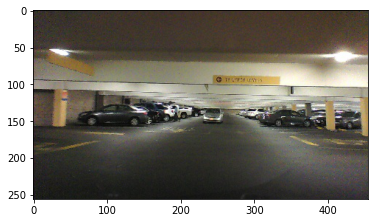

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

img = plt.imread('/content/drive/MyDrive/self_driving_data/driving_dataset/123.jpg')
plt.imshow(img)
plt.show()

# ~Shuffle data randomly~


In [ ]:
import random

c = list(zip(xs,ys))
random.shuffle(c)
xs,ys = zip(*c)

# Data generator

In [30]:
import cv2
from tensorflow.keras.utils import Sequence
import numpy as np

'''
=============================
x_train = []
y_train = []

x_val = []
y_val = []

for i,id in enumerate(train_xs[:100]):
  img = cv2.imread('/content/drive/MyDrive/self_driving_data/'+str(id))
  img = cv2.resize(img[-150:], (200,66))/255

  x_train.append(img)
  y_train.append(train_ys[i])

for i,id in enumerate(val_xs[:100]):
  img = cv2.imread('/content/drive/MyDrive/self_driving_data/'+str(id))
  img = cv2.resize(img[-150:], (200,66))/255

  x_val.append(img)
  y_val.append(val_ys[i])
=============================
'''

# Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(66,200,3), shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty(self.batch_size)
    
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      img = cv2.imread('/content/drive/MyDrive/self_driving_data/driving_dataset/'+str(ID))
      img = cv2.resize(img[-150:], (200,66))/255
      
      # Store sample
      X[i,] = img
        
      # Store class
      y[i] = float(self.labels[ID])
        
    return X, y

# Get xs and ys from data.txt

In [ ]:
xs = []
ys = []

with open('/content/drive/MyDrive/self_driving_data/driving_dataset/data.txt') as f:
  for line in f:
    xs.append(line.split()[0])
    ys.append(float(line.split()[1]) * 3.14159265 / 180)

num_images = len(xs)
print(xs)

# Train and validation split

In [32]:
'''
=============================
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)
=============================
'''

partition = {'train':xs[:int(len(xs)*0.8)],'validation':xs[-int(len(xs) * 0.2):]}
labels = dict(zip(xs,ys))

# Build model

In [33]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
import tensorflow as tf

INIT_LR = 1e-4

def build_model():
  model = Sequential()

  # 5x5 Convolutional layers with stride of 2x2
  model.add(Conv2D(24, (5, 5), strides=(2, 2),activation='elu',input_shape=(66,200,3)))
  model.add(Conv2D(36, (5, 5), strides=(2, 2),activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2),activation='elu'))
      
  # 3x3 Convolutional layers with stride of 1x1
  model.add(Conv2D(64, (3, 3),activation='elu'))
  model.add(Conv2D(64, (3, 3),activation='elu'))
      
  # Flatten before passing to the fully connected layers
  model.add(Flatten())

  # Three fully connected layers
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(.25))
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(.25))
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(.25))
      
  # Output layer with linear activation 
  model.add(Dense(1,activation="linear"))

  return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

# Train model

In [36]:
import os

checkpoint_path = "/content/save/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Parameters for datagenerator
params = {'dim': (66,200,3),
          'batch_size': 32,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition["train"], labels, **params)
validation_generator = DataGenerator(partition["validation"], labels, **params)

model.compile(optimizer='adam', loss="mse")

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
#train it for 10 epochs
model.fit_generator(generator=training_generator,epochs=10,validation_data=validation_generator,callbacks=[cp_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1135/1135 [==============================] - 1102s 971ms/step - loss: 0.2999 - val_loss: 0.2053

Epoch 00001: val_loss improved from inf to 0.20535, saving model to /content/save/cp.ckpt
Epoch 2/10
1135/1135 [==============================] - 489s 431ms/step - loss: 0.2547 - val_loss: 0.3038

Epoch 00002: val_loss did not improve from 0.20535
Epoch 3/10
1135/1135 [==============================] - 457s 402ms/step - loss: 0.2364 - val_loss: 0.2624

Epoch 00003: val_loss did not improve from 0.20535
Epoch 4/10
1135/1135 [==============================] - 440s 388ms/step - loss: 0.1957 - val_loss: 0.5054

Epoch 00004: val_loss did not improve from 0.20535
Epoch 5/10
1135/1135 [==============================] - 462s 407ms/step - loss: 0.1669 - val_loss: 0.2773

Epoch 00005: val_loss did not improve from 0.20535
Epoch 6/10
1135/1135 [==============================] - 481s 424ms/step - loss: 0.1876 - val_loss: 0.1984

Epoch 00006: val_loss improved from 0.20535 to 0.19842, saving 

In [48]:
model.save('/content/save/model.h5')

In [51]:
def build_model():
  model = Sequential()

  # 5x5 Convolutional layers with stride of 2x2
  model.add(Conv2D(24, (5, 5), strides=(2, 2),activation='elu',input_shape=(66,200,3)))
  model.add(Conv2D(36, (5, 5), strides=(2, 2),activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2),activation='elu'))
      
  # 3x3 Convolutional layers with stride of 1x1
  model.add(Conv2D(64, (3, 3),activation='elu'))
  model.add(Conv2D(64, (3, 3),activation='elu'))
      
  # Flatten before passing to the fully connected layers
  model.add(Flatten())

  # Three fully connected layers
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(.25))
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(.25))
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(.25))
      
  # Output layer with linear activation 
  model.add(Dense(1,activation="linear"))

  return model

# Evaluate model

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow

model = build_model()
model.compile(optimizer='adam', loss="mse")

model.load_weights(filepath=checkpoint_path)

wheel = cv2.imread('/content/steering_wheel_image.jpg')

wheel = cv2.resize(wheel, (270, 210))
rows, cols, level = wheel.shape

i = 0
smooth_angle = 0
while(cv2.waitKey(10) != ord('q')):
    image = cv2.imread('/content/drive/MyDrive/self_driving_data/driving_dataset/'+str(i) + ".jpg")
    image_show = image
    image = cv2.resize(image[-150:], (200, 66))
    image = img_to_array(image)/255

    cv2_imshow(cv2.resize(image_show, (800, 398)))

    result = -model.predict(image[None])*180.0/3.14159265
    print("Actual Angle = {} Predicted Angle = {}".format(
        str(ys[i]), str(-result)))

    # this section just for the smoother rotation of streeing wheel.
    smooth_angle += 0.2 * pow(abs((result - smooth_angle)),
                              2.0/3.0)*(result - smooth_angle)/abs(result-smooth_angle)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), smooth_angle, 1)
    dst = cv2.warpAffine(wheel, M, (cols, rows))

    cv2_imshow(dst)
    i+=1

cv2.destroyAllWindows()


In [68]:
model.evaluate(validation_generator)

283/283 [==============================] - 65s 228ms/step - loss: 0.1986


0.19863690435886383